In [156]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import descartes
import geopandas as gpd
from Levenshtein import distance
from itertools import product
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Point, Polygon
# from sklearn.impute import KNNImputer
# from impyute.imputation.cs import mice
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import OneHotEncoder
import math
import pickle
import warnings
warnings.filterwarnings('ignore')

In [157]:
# load data
d = pd.read_csv("US_Accidents_May19.csv")

In [158]:
d

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243934,A-2243935,Bing,NaN,2,2017-08-30 20:01:40,2017-08-31 02:01:40,34.055160,-118.214070,34.058220,-118.214270,...,False,False,False,False,False,False,Night,Night,Day,Day
2243935,A-2243936,Bing,NaN,2,2017-08-30 20:01:40,2017-08-31 02:01:40,34.046740,-118.214800,34.055160,-118.214070,...,False,False,False,False,False,False,Night,Night,Day,Day
2243936,A-2243937,Bing,NaN,3,2017-08-30 20:03:10,2017-08-31 02:03:10,34.031850,-117.135910,34.025370,-117.116160,...,False,False,False,False,False,False,Night,Night,Day,Day
2243937,A-2243938,Bing,NaN,4,2017-08-30 20:49:40,2017-08-31 02:49:40,34.277860,-118.608280,34.266581,-118.640372,...,False,False,False,False,False,False,Night,Night,Night,Night


# Data Overview

### We will first discuss about each attribute and discuss what it stands for:
- ID:- A unique identifier for each accident.
- Source:- The source which reported the accident. 
- TMC:- It is Traffic Messagen Channel which providea more detailed description of the event.
- Severity:- The level of impact of the accident. 1 being the lowest and 4 being the highest.
- Start_Time:- Shows start time of the accident in local time zone.
- End_Time:- Shows end time of the accident in local time zone.
- Start_Lat:- Shows latitude in GPS coordinate of the start point.
- Start_Lng:- Shows longitude in GPS coordinate of the start point.
- End_Lat:- Shows latitude in GPS coordinate of the end point.
- End_Lng:- Shows longitude in GPS coordinate of the end point.
- Distance(mi)-: The length of the road extent affected by the accident.
- Description:- The description of the accident.
- Number:- Street Number
- Street:- Street Name
- Side:- Relative side of the address field.
- City:- Name of the City.
- County:- Name of the county.
- State:- Name of the state.
- Zipcode:- Zipcode of the address
- Country:- Name of the country
- Timezone:- Timezone of the location where accident occurred
- Airport_Code:- Denotes an airport-based weather station which is the closest one to location of the accident.
- Weather_Timestamp:- Shows the time-stamp of weather observation record
- Temperature(F) :- Temperature in Fahrenheit
- Wind_Chill(F):- Wind chill in Fahrenheit
- Humidity(%):- Humidity in percentage
- Pressure(in):- Air pressure in inches
- Visibility(mi):- Visibilty in miles.
- Wind_Direction:- Wind direction
- Wind_Speed(mph):- Wind speed in miles per hour.
- Precipitation(in): -Precipitation in inches.
- Weather_Condition: Shows what was the weather that day, i.e., if it was rainy, sunny, etc.
- Amenity:- A Point-Of-Interest (POI) annotation which indicates presence of amenity in a nearby location.
- Bump: Tells whether there was any bump on the road.
- Crossing:- Tells whether there was any corssing on the road.
- Give_Way:- Tells whether there was any give-way sign on the road.
- Junction:- Tells whether ther was any junction present.
- No_Exit:- Tells whether there was any no-exit sign on the road.
- Railway:-  Tells whether ther was any railway present nearby.
- Roundabout:- Tells whether ther was any roundabout present nearby.
- Station:- Tells whether there was any sytation present.
- Stop:- Tells whether there was any Stop sign on the road.
- Traffic_Calming:-  Tells whether ther was any Traffic-calming means present nearby.
- Traffic_Signal:- Tells whether there was any taffic signal nearby.
- Turning_Loop:- Tells whether there was any turning loop nearby.
- Sunrise_Sunset::- Tells us the period of the day based on sunrise or suset.
- Civil_Twilight:- Tells us the period of the day based on civil twilight.
- Nautical_Twilight:- Tells us the period of the day based on nautical twilight.
- Astronomical_Twilight:- Tells us the period of the day based on astrnomical twilight.

### Now we will see the percentage of accidents reported by each reporting source.  

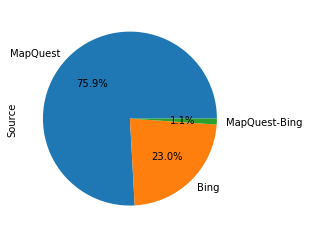

In [159]:
d.Source.value_counts().plot(kind='pie', autopct='%1.1f%%', )

#### We can see that majority of the reports came from MapQuest. 

### Now we shall see how many high severity cases were reported by each reporting source.

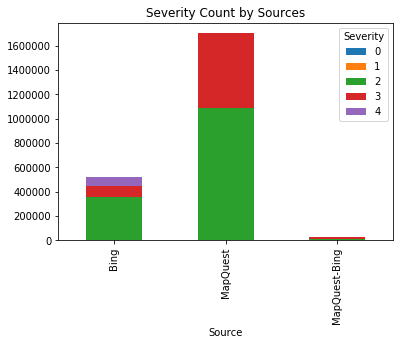

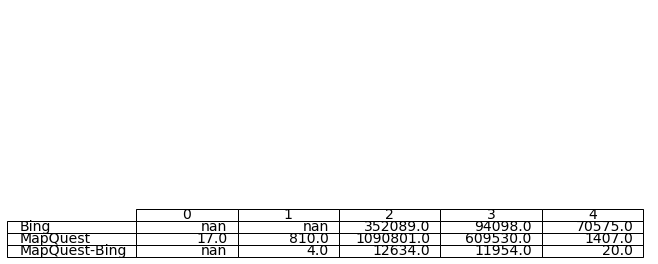

In [160]:
import matplotlib.pyplot as plt
from pandas.plotting import table

source = d.groupby(['Source', 'Severity']).size().reset_index().pivot(columns='Severity', index='Source', values=0)

# plot bar graph
source.plot(kind='bar', stacked='True', title='Severity Count by Sources')
plt.figure(figsize=(20,8))

# plot table
ax1 = plt.subplot(222)
plt.axis('off')
tbl = table(ax1, source)
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
plt.show()

#### We observe that though MapQuest reported maximum number of accidents, Severity level 4 accidents were reported less compared to Bing though Severity level 3 accidents count is highest for MapQuest. But we also notice that Bing doesn't report any severity level 0 and 1 cases. These differences may occur when different sources tend to collect data on the basis of their preference for severity level. Other case that might be there is that they may have different definitions for severity level. If the latter is true, we cannot use data from both the sources at the same time. To conform that, we will check the impacted distance and duration for the severity levels.

### We will create scatterplots of duration and impacted distance with respect to severity levels for each reporting source.

In [161]:
# first of all, we will fix the time column.
d['Start_Time'] = pd.to_datetime(d['Start_Time'])
d['End_Time'] = pd.to_datetime(d['End_Time'])

# calculate duration by finding difference of end_time and start_time and converting in minutes.
d['Duration'] = d.End_Time - d.Start_Time 
d['Duration'] = d['Duration'].apply(lambda x:round(x.total_seconds() / 60) )

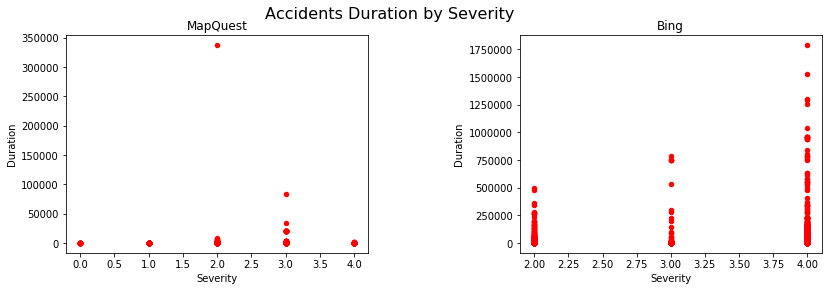

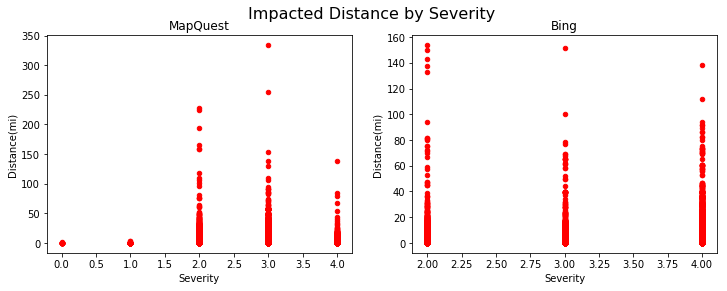

In [162]:
map_quest = d[d.Source == 'MapQuest']
bing = d[d.Source == 'Bing']

# plot scatterplots for Duration
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
plt.subplots_adjust(right=1, wspace = 0.5)
axs[0].set_title("MapQuest")
axs[1].set_title("Bing")
fig.suptitle('Accidents Duration by Severity', fontsize=16)
map_quest.plot.scatter(x='Severity', y='Duration', c='red', ax=axs[0])
bing.plot.scatter(x='Severity', y='Duration', c='red', ax=axs[1])
plt.show()

# plot scatterplots for Distance
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].set_title("MapQuest")
axs[1].set_title("Bing")
fig.suptitle('Impacted Distance by Severity', fontsize=16)
map_quest.plot.scatter(x='Severity', y='Distance(mi)', c='red', ax=axs[0])
bing.plot.scatter(x='Severity', y='Distance(mi)', c='red', ax=axs[1])
plt.show()

#### As we can see, both the sources follow different definition for severtity. So one thing is for sure, we cannot use data form both the sources. But now the problem which source to rely on. If we go with the "Accidents duarion by Severity", "Bing" seems to be more reliable as it has reported high severity for accidents with higher duarion. But when we observe the plots for "Impacted distance by Severity", we see even higher distances have been reported as severity level 2 by "Bing", which seems incorrect. Thus, it would be a subjective approach of the person who does analysis. Therefore, I am going with the data reported by MapQuest

### Now we shall analyze numerical and categorical data seperately

In [163]:
numerical = map_quest._get_numeric_data().columns
categorical = list(set(map_quest.columns) - set(numerical))
print("NUMERICAL")
print(list(numerical))
print("CATEGORICAL")
print(categorical)

NUMERICAL
['TMC', 'Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Duration']
CATEGORICAL
['Description', 'Nautical_Twilight', 'Start_Time', 'ID', 'State', 'Zipcode', 'End_Time', 'Street', 'Civil_Twilight', 'Weather_Condition', 'County', 'City', 'Astronomical_Twilight', 'Side', 'Airport_Code', 'Timezone', 'Weather_Timestamp', 'Wind_Direction', 'Country', 'Source', 'Sunrise_Sunset']


### We notice that columns like Amenity, Bump, etc. which have binary values (True/False) are considered numerical here. Thus, it should be converted to categorical variables. And Weather_Timestamp, which is supposed to have a time datatype is considered numerical here. We need to change that as well.

In [164]:
# fixing Weather_Timestamp
map_quest['Weather_Timestamp'] = pd.to_datetime(map_quest['Weather_Timestamp'])

# converting certain numerical variables to categorical variables
# num_to_cat_var = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 
#                  'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
# for i in num_to_cat_var:
#     map_quest[i] = map_quest[i].astype('category', copy=False)
    
# we will convert the severity variable also to a ordinal variable
map_quest['Severity'] = pd.Categorical(map_quest['Severity'], ordered=True)

### Since we have all the variables in their required formats, we can now see how many classes does each categorical variable have. We can drop labels with 1 class since that won't be helping our cause.

In [165]:
refined_categories = list(set(map_quest.columns) - set(map_quest._get_numeric_data().columns))
for i in refined_categories:
    print(i, map_quest[i].unique().size)

Description 1057455
Start_Time 1665134
ID 1702565
State 49
Zipcode 256323
End_Time 1656448
Street 111601
Civil_Twilight 3
Weather_Condition 61
County 1532
City 9572
Country 1
Astronomical_Twilight 3
Side 3
Severity 5
Airport_Code 1764
Timezone 5
Weather_Timestamp 316494
Wind_Direction 19
Nautical_Twilight 3
Source 1
Sunrise_Sunset 3


#### We are going to drop Country, Turning_Loop and Source since they have 1 class and are going to be helpful for modelling. 

In [166]:
map_quest.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Duration'],
      dtype='object')

In [167]:
# drop certain categories
map_quest = map_quest.drop(['ID', 'Country', 'Turning_Loop', 'Source'], axis=1)

In [168]:
# convert description to a string variable
# map_quest['Description'] = map_quest['Description'].astype('string')

### Now we will examine whether we need  Weather_Timestamp

In [169]:
print("Mean difference between 'Start_Time' and 'Weather_Timestamp': ", 
      (map_quest.Weather_Timestamp - map_quest.Start_Time).mean())

Mean difference between 'Start_Time' and 'Weather_Timestamp':  0 days 00:00:28.205891


#### Since there is no difference in the Weather_Timestamp and Start_Time, we will drop Weather_Timestamp

In [170]:
# drop Weather_Timestamp
map_quest = map_quest.drop(['Weather_Timestamp'], axis=1)

In [171]:
# We will map the Start_Time to year, month and minute
map_quest['year'] = map_quest['Start_Time'].dt.year
map_quest['month'] = map_quest['Start_Time'].dt.month
map_quest['minute'] = map_quest['Start_Time'].dt.minute + (map_quest['Start_Time'].dt.hour * 60.0)

In [172]:
# drop Start_Time
map_quest = map_quest.drop(['Start_Time'], axis=1)

# Handling missing values

### First of all, we will check which all labels have some null values.

In [173]:
# missing value percentage calculation
missing = pd.DataFrame(map_quest.isnull().sum()).reset_index()
missing.columns = ['Labels', 'Percentage']
missing['Percentage'] = missing['Percentage'].apply(lambda x: (x/map_quest.shape[0])*100)
missing.loc[missing['Percentage'] > 0, :].sort_values(by=['Percentage'], ascending=False)

,Labels,Percentage
5,End_Lat,100.000000
6,End_Lng,100.000000
25,Precipitation(in),88.404496
19,Wind_Chill(F),83.106196
9,Number,60.877147
24,Wind_Speed(mph),19.822444
26,Weather_Condition,2.961355
22,Visibility(mi),2.937333
20,Humidity(%),2.615231
18,Temperature(F),2.519023


### Columns like End_Lat and End_Lan have no values in their column. Therefore, it is better if we remove it. 
#### So the columns dropped are:
- End_Lat
- End_Lng
- Precipitation(in)
- Wind_Chill(F)
- Number

In [174]:
# drop columns
map_quest = map_quest.drop(['End_Lat', 'End_Lng', 'Precipitation(in)', 'Wind_Chill(F)', 'Number'], axis=1)

### Columns like Astronomical_Twilight, City have null percentage less than 1, so we can just drop rows.

In [175]:
# drop rows
map_quest = map_quest.dropna(subset=['City', 'Astronomical_Twilight', 'Nautical_Twilight', 'Civil_Twilight', 
                                    'Sunrise_Sunset', 'Zipcode', 'Timezone', 'Airport_Code'])

### Now there are some columns which have null percentage more than 1 but still very less which don't need to be dropped. We can impute values in those. 
### The columns whose values will be imputed are:-
- Wind_Direction
- Pressure(in)
- Temperature(F)
- Humidity(%)
- Visibility(mi)
- Weather_Condition
- Wind_Speed(mph)

### Value imputation
Since this is a huge dataset, techniques like KNNImputer or MICE will take a lot of time, even days, which will
be computationally very expensive for me. Thus, I will be filling nan values with mean values.

In [176]:
# For numeric variables, I will be using mean values
map_quest['Pressure(in)'] = map_quest['Pressure(in)'].fillna(map_quest['Pressure(in)'].mean())
map_quest['Temperature(F)'] = map_quest['Temperature(F)'].fillna(map_quest['Temperature(F)'].mean())
map_quest['Humidity(%)'] = map_quest['Humidity(%)'].fillna(map_quest['Humidity(%)'].mean())
map_quest['Visibility(mi))'] = map_quest['Visibility(mi)'].fillna(map_quest['Visibility(mi)'].mean())
map_quest['Wind_Speed(mph)'] = map_quest['Wind_Speed(mph)'].fillna(map_quest['Wind_Speed(mph)'].mean())

In [177]:
# data imputation for categorical variables
x = map_quest[['Wind_Direction', 'Weather_Condition']].values
imputer = CategoricalImputer()
x = imputer.fit_transform(x)
map_quest['Wind_Direction'] = x[:, 0]
map_quest['Weather_Condition'] = x[:, 1]

In [178]:
# missing value percentage calculation
missing = pd.DataFrame(map_quest.isnull().sum()).reset_index()
missing.columns = ['Labels', 'Percentage']
missing['Percentage'] = missing['Percentage'].apply(lambda x: (x/map_quest.shape[0])*100)
missing.loc[missing['Percentage'] > 0, :].sort_values(by=['Percentage'], ascending=False)

,Labels,Percentage
18,Visibility(mi),2.019643
6,Description,0.000059


In [179]:
# we will drop the rest of the null values for the sake of simplicity
map_quest = map_quest.dropna(subset=['Visibility(mi)', 'Description'])

#### Now as all the missing values have been handled, we will dive further deep into data analysis.

# Exploratory Data Analysis 

### Now we will check how much accidents (of each severity level) happened in each year. 

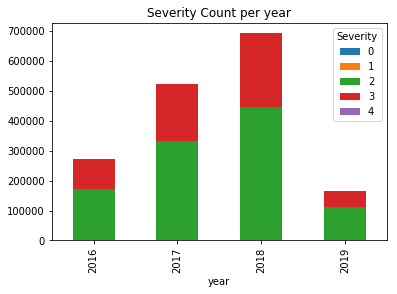

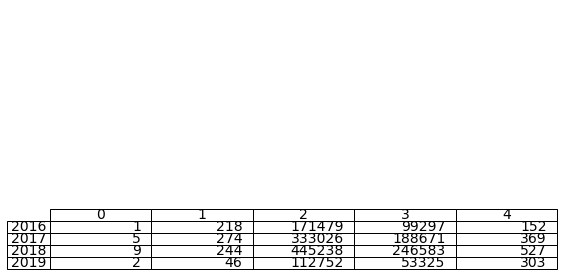

In [180]:
# plot bar graph for accidents per year
accidents = map_quest.groupby(['year', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='year', values=0)

accidents.plot(kind='bar', stacked=True, title='Severity Count per year')
plt.figure(figsize=(20,8))

# # plot table
ax1 = plt.subplot(222)
plt.axis('off')
tbl = table(ax1, accidents)
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
plt.show()

#### As we can see, most of the accidents happened in each year is of severity level 2 followed by severity level 3.  And the table shows that count of other severity level accidents are very low. This class imbalance represents either accidents of severity level 4 has happened very low or it has not been reported.  Another thing worth noticing is that accident counts were increasing over the years but suddenyl dropped at a drastic level in 2019 which again shows either accidents reduced due to some rules and regulation being followed rigorously or low cases were reorted by the source, in our case MapQuest. But in any way, class is highly imbalanced.

### Now we will check number of accidents haapening month-wise to check whether we can see any pattern in that

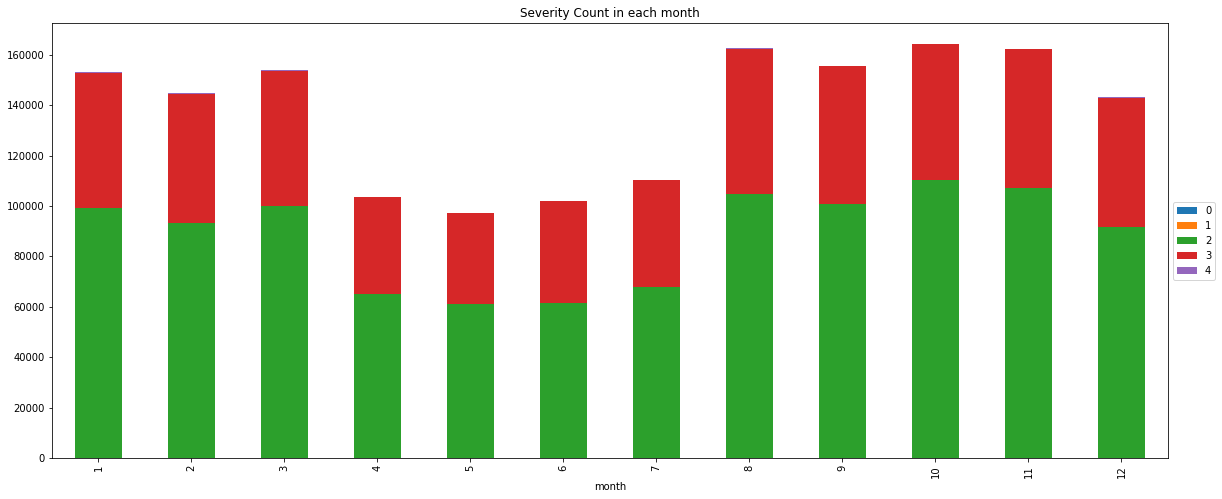

In [181]:
accidents = map_quest.groupby(['month', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='month', values=0)

accidents.plot(kind='bar', stacked=True, figsize=(20,8), title='Severity Count in each month').legend(loc='center left',
                                                                                                      bbox_to_anchor=(1.0, 0.5))

#### All we can see is that most of the accidents happened in January to March and then August to December. It is quite an interesting find and there may be some relation with the weather so we will check that out.

### Now we will check the number of accidents based on the weather condition.

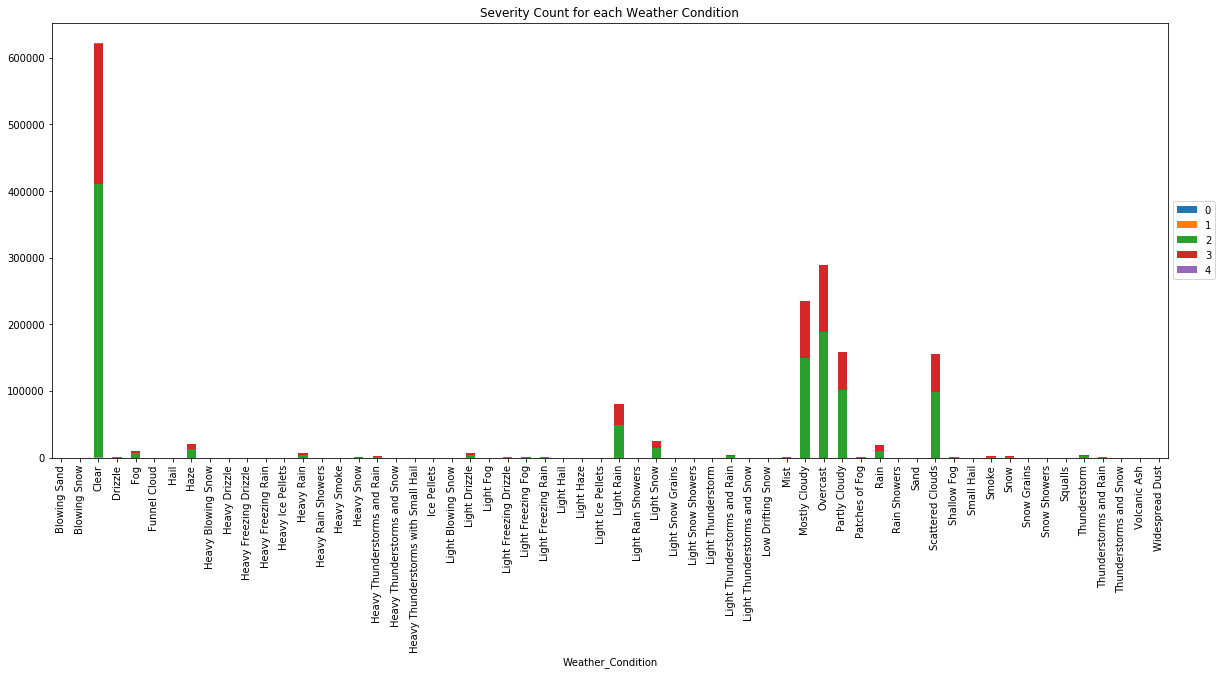

In [182]:
accidents = map_quest.groupby(['Weather_Condition', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='Weather_Condition', values=0)

accidents.plot(kind='bar', stacked=True, figsize=(20,8), title='Severity Count for each Weather Condition').legend(loc='center left',
                                                                                        bbox_to_anchor=(1.0, 0.5))

### We don't any anomaly here as most of the accidents have happened on clear days. But we will investigate for specifically severity level 4.

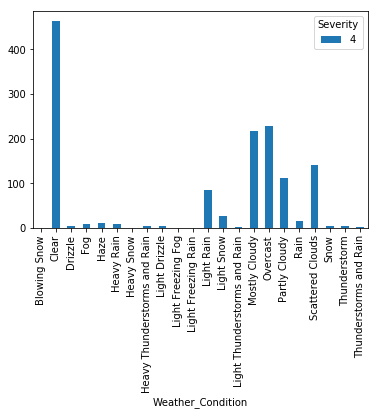

In [183]:
severe_4 = map_quest[map_quest.Severity == 4]
accidents = severe_4.groupby(['Weather_Condition', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='Weather_Condition', values=0)
accidents.plot(kind='bar')

#### Clearly there is no anomaly in this as most of the accidents happened on clear days. That may mean the accidents don't have any particular reason for happening mostly in October.

### Now we will check whether accidents are happening during day or night. For that, we will take 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight'and 'Astronomical_Twilight'.

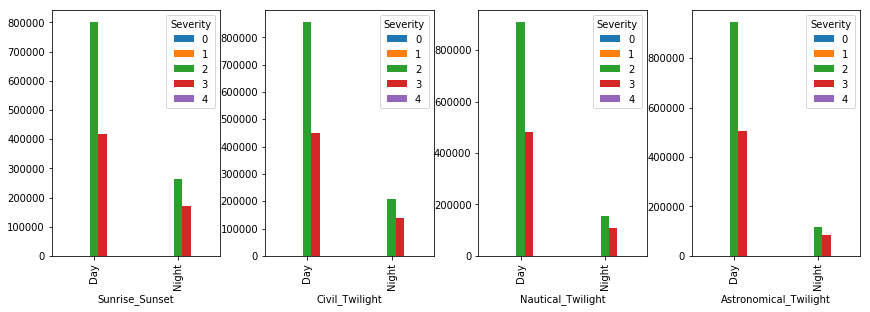

In [184]:
frame = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
fig, axs = plt.subplots(ncols=4, figsize=(12, 4))
fig.tight_layout()
for i,feature in enumerate(frame):
    accidents = map_quest.groupby([feature, 'Severity']).size().reset_index().pivot(columns=
                                                            'Severity', index=feature, values=0)
    accidents.plot(kind='bar', ax=axs[i])

#### We observe that most of the accidents happened during the day but more of less severity and during the night, although the accidents happened less, the margin between the high and low severity is less.

### We will check which state has the most number of accidents.

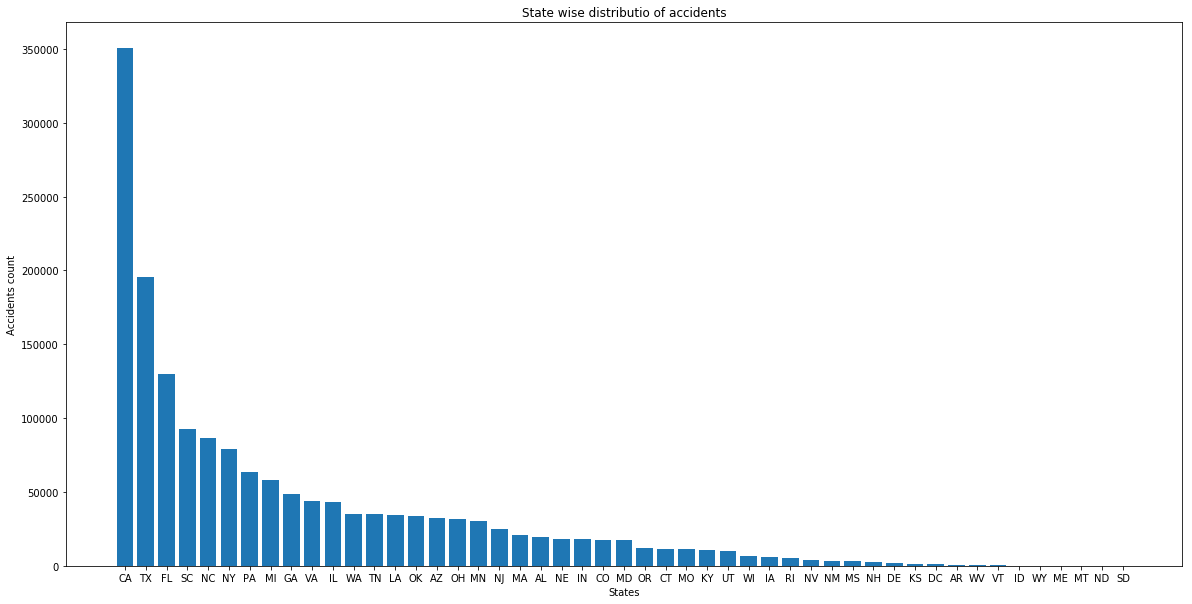

In [185]:
accidents = map_quest.State.value_counts().to_frame().reset_index()
accidents.columns = ['State', 'Accidents']
accidents = accidents.sort_values(by='Accidents', ascending=False)

objects = list(accidents.State)
y_pos = np.arange(len(objects))
Numbers = list(accidents.Accidents)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.xlabel('States')
plt.ylabel('Accidents count')
plt.title('State wise distributio of accidents')
plt.show()

#### We see that CA and TX consists of majority of the accidents. Now, we will dig further deep and see which state has more severity level 4 accidents.

### Now we will see which state happens to have most number of accidents of severity level 4

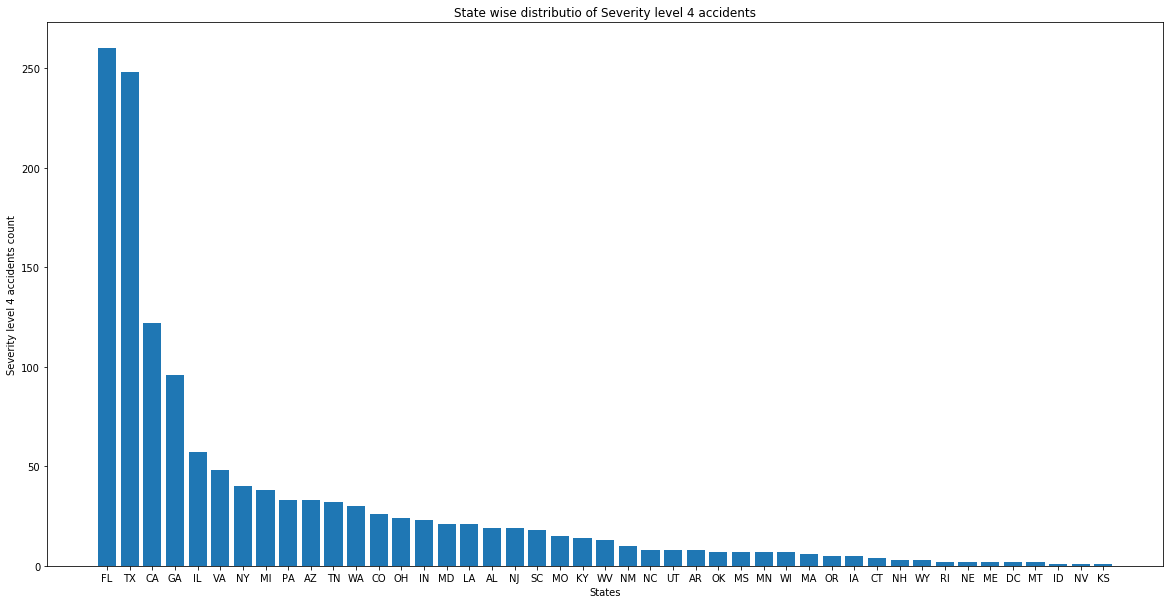

In [186]:
severe_4 = map_quest[map_quest.Severity == 4].State.value_counts().to_frame().reset_index()
severe_4.columns = ['State', 'Accidents']
severe_4 = severe_4.sort_values(by='Accidents', ascending=False)

objects = list(severe_4.State)
y_pos = np.arange(len(objects))
Numbers = list(severe_4.Accidents)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.xlabel('States')
plt.ylabel('Severity level 4 accidents count')
plt.title('State wise distributio of Severity level 4 accidents')
plt.show()

#### So FL and TX consists of majority of the accidents of Severity level 4. 

### Now let's plot the accidents on a map 

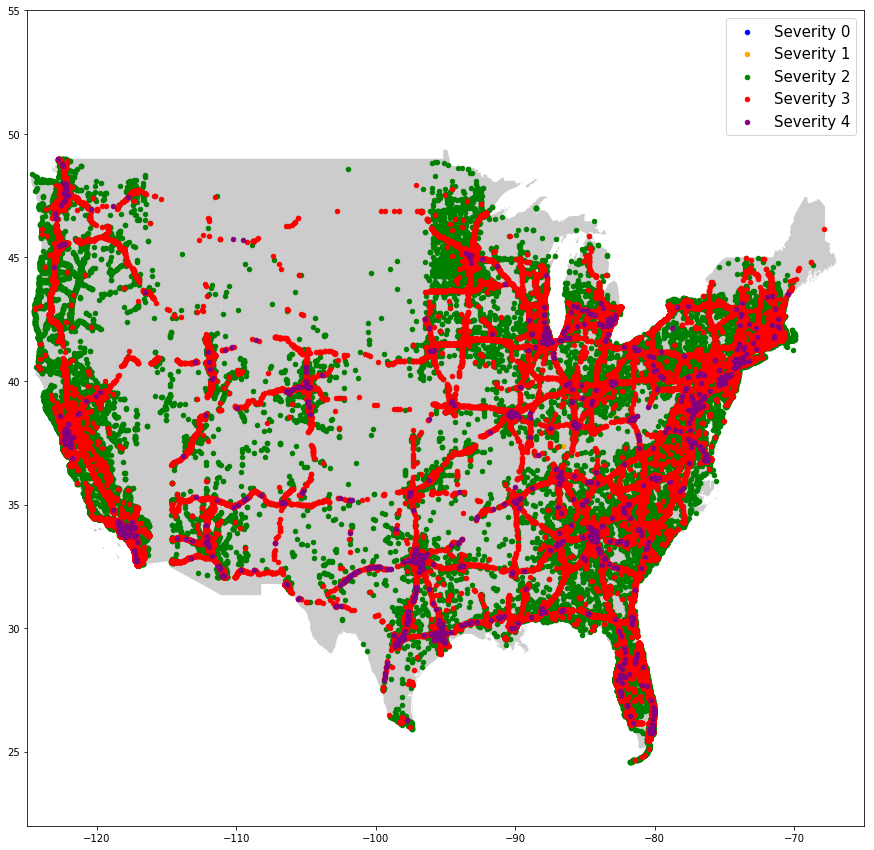

In [187]:
geometry = [Point(xy) for xy in zip(map_quest['Start_Lng'], map_quest['Start_Lat'])]
geo_df = gpd.GeoDataFrame(map_quest, geometry=geometry)


us_map = gpd.read_file('cb_2018_us_state_500k.shp')
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
us_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['Severity'] == 0].plot(ax=ax, markersize=20, color='blue', marker='o', label='Severity 0')
geo_df[geo_df['Severity'] == 1].plot(ax=ax, markersize=20, color='orange', marker='o', label='Severity 1')
geo_df[geo_df['Severity'] == 2].plot(ax=ax, markersize=20, color='green', marker='o', label='Severity 2')
geo_df[geo_df['Severity'] == 3].plot(ax=ax, markersize=20, color='red', marker='o', label='Severity 3')
geo_df[geo_df['Severity'] == 4].plot(ax=ax, markersize=20, color='purple', marker='o', label='Severity 4')
plt.legend(prop={'size': 15})

#### We see from this map that accidents of severity level 0 are rarely reported. 

### We will see whether the numerical variables are normalized or not

Pressure(in)


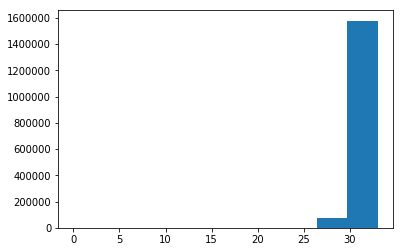

Temperature(F)


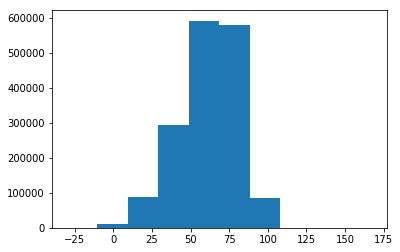

Humidity(%)


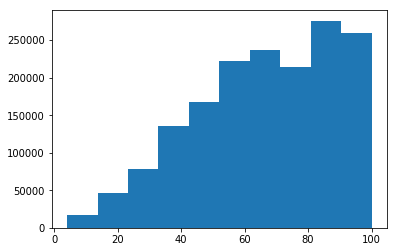

Visibility(mi)


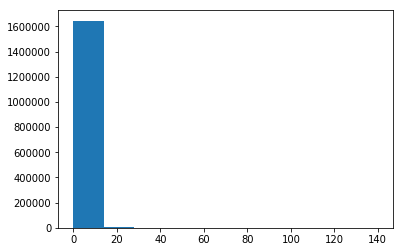

Wind_Speed(mph)


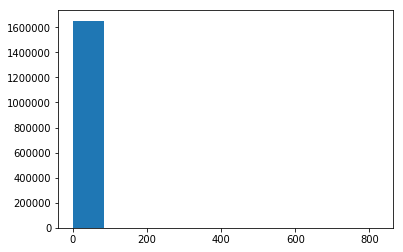

In [188]:
numerical_vars = ['Pressure(in)', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)']

for i in numerical_vars:
    print(i)
    plt.hist(map_quest[i])
    plt.show()

### Certain variables have too many categories and it is not wise to create dummies for them since it will increase dimensions to a large extent. Thus for those variables, we will do "Frequency Encoding" and give them a log transformation. The variables are:-
- County
- Zipcode
- City
- Airport_Code
- Street

In [189]:
map_quest['Zipcode'].unique()

array(['45424', '43068-3402', '45176', ..., '93561-6231', '92376-5157',
       '92530-1613'], dtype=object)

### We see that there are some values which contains '-' following some number which is used by postal services to make it easier for postmen to locate the addresses. But, here in our case it os creating duplicates. Thus we will remove those anything after '-'.

In [190]:
map_quest['Zipcode'] = map_quest['Zipcode'].str.replace(r'-\d+', '')

In [191]:
map_quest['County'] = map_quest['County'].str.lower()

In [192]:
len(map_quest['County'].unique())

1485

### We see that there are 1485 unique values. Although we are clear with not having any missing values, but there are high chences that there might be spelling mistakes which creates redundancies.

In [193]:
a = map_quest.County.value_counts().index.tolist()
transformed_strings = np.array(a).reshape(-1,1)

df = pd.DataFrame(squareform(pdist(transformed_strings,lambda x,y: distance(x[0],y[0]))), columns = a, index = a)

In [194]:
df.reset_index(level=0, inplace=True)
d = pd.melt(df, id_vars=['index'], value_vars=a)
d = d.sort_values(by='value')
d = d[d.value > 0]

In [195]:
d

,index,variable,value
624730,coosa,coos,1.0
107636,alleghany,allegheny,1.0
2088081,anoka,atoka,1.0
169797,prince georges,prince george's,1.0
588812,de soto,desoto,1.0
...,...,...,...
407673,colonial heights city,brown,20.0
1959498,colonial heights city,frio,20.0
909603,colonial heights city,grand,20.0
1162985,westmoreland,colonial heights city,20.0


In [121]:
# for exhaustive analysis 
d.to_csv('Levenshtein.csv')

In [196]:
map_quest['County'] = map_quest['County'].str.replace('de soto','desoto')
map_quest['County'] = map_quest['County'].str.replace('de witt','dewitt')
map_quest['County'] = map_quest['County'].str.replace("queen annes","queen anne's")
map_quest['County'] = map_quest['County'].str.replace('alleghany','alleghney')
map_quest['County'] = map_quest['County'].str.replace("prince georges","prince george's")
map_quest['County'] = map_quest['County'].str.replace('st john the baptist','st. john the baptist')

In [197]:
map_quest['Street'] = map_quest['Street'].str.lower()

In [198]:
len(map_quest['Street'].unique())

108877

### As we can see, there are too many values and it would be really dificult to check. Therefore, we leave it like that for now.

In [199]:
map_quest['City'] = map_quest['City'].str.lower()

In [200]:
len(map_quest['City'].unique())

9170

In [201]:
a = map_quest.City.value_counts().index.tolist()
transformed_strings = np.array(a).reshape(-1,1)

df = pd.DataFrame(squareform(pdist(transformed_strings,lambda x,y: distance(x[0],y[0]))), columns = a, index = a)

In [202]:
df.reset_index(level=0, inplace=True)
d = pd.melt(df, id_vars=['index'], value_vars=a)
d = d.sort_values(by='value')
d = d[d.value == 1]

In [203]:
d

,index,variable,value
8282406,newtown,newton,1.0
14811962,middlebury,middleburg,1.0
32029387,linkwood,linwood,1.0
12721351,wilson,wilton,1.0
16355474,hixton,hilton,1.0
...,...,...,...
82086985,hines,haines,1.0
1581183,dolton,colton,1.0
23485757,wilton,wilson,1.0
7511097,patterson,paterson,1.0


In [ ]:
# for exhaustive analysis 
d.to_csv('Levenshtein_City.csv')

### Based on my analysis, the spellings are correct.

In [204]:
var_list = ['County', 'Zipcode', 'Airport_Code', 'Street', 'City']

for i in var_list:
    new_var = i + '_freq'
    map_quest[new_var] = map_quest.groupby([i])[i].transform('count')
    map_quest[new_var] = map_quest[new_var]/map_quest.shape[0]*map_quest[i].unique().size

### Now I will save the mappings to use it during deployment.

In [205]:
d = {}
for i in var_list:
    d[i] = pd.DataFrame()

for i in var_list:
    d[i] = map_quest[[i, i + '_freq']].groupby(i).mean()
    d[i] = d[i].reset_index()

In [206]:
# saving the csv files
# for i in var_list:
#     d[i].to_csv(i+".csv")

In [207]:
dic = {}
for i in var_list:
    dic[i] = open(i+'.pkl', 'wb')
    pickle.dump(d[i], dic[i])
    dic[i].close()

In [208]:
# drop the original columns
map_quest = map_quest.drop(['City', 'County', 'Zipcode', 'Airport_Code', 'Street'], axis=1)

### Now we check POI (Point Of Interests) variables. 

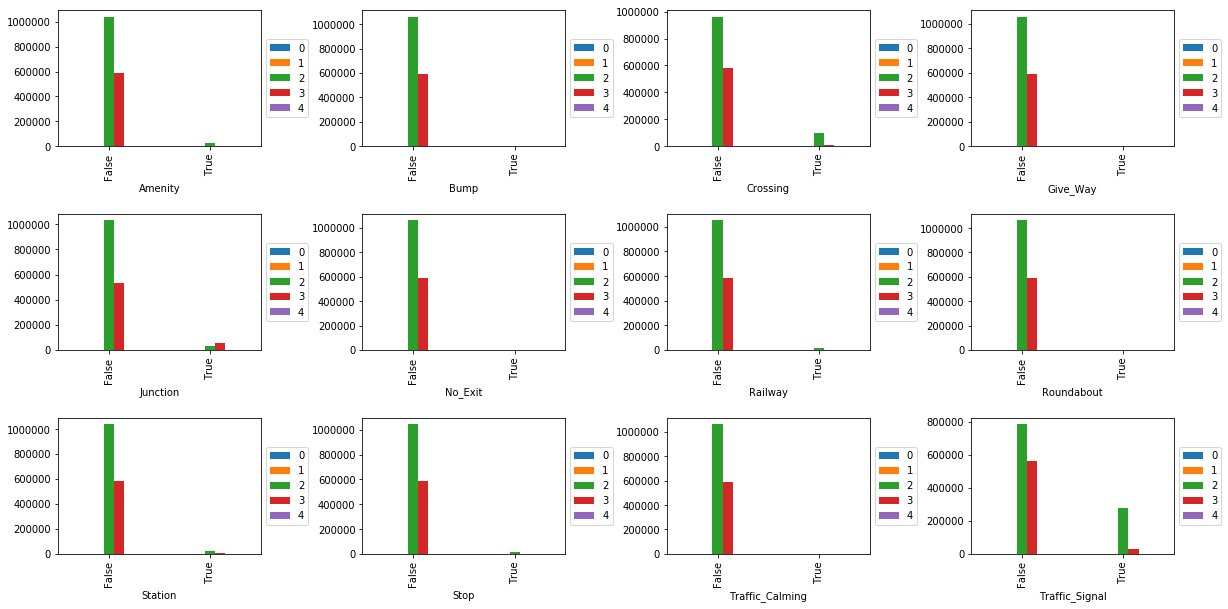

In [209]:
frame = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway',
         'Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,10))
plt.subplots_adjust(hspace=0.5,wspace = 0.5)
j = 0
for i,feature in enumerate(frame):
    accidents = map_quest.groupby([feature, 'Severity']).size().reset_index().pivot(columns=
                                                            'Severity', index=feature, values=0)
    if i < 4:
        accidents.plot(kind='bar', ax=axs[j,i]).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        if i < 8:
            accidents.plot(kind='bar', ax=axs[1,i-4]).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        else:
            accidents.plot(kind='bar', ax=axs[2,i-8]).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Few of the columns are highly imabalanced, so we will remove the following columns:
- Bump
- Give_Way
- No_Exit
- Roundabout
- Traffic_Calming

In [210]:
map_quest = map_quest.drop(['Bump', 'Give_Way', 'No_Exit', 'Roundabout', 'Traffic_Calming'], axis=1)

In [211]:
# map_quest._get_numeric_data().columns

### Columns such as 'year' and 'minute' should be removed since they are not useful.

In [212]:
# drop year and minute
map_quest = map_quest.drop(['year', 'minute', 'TMC'], axis=1)

In [213]:
# convert month as categorical
# map_quest['month'] = pd.Categorical(map_quest['month'])

### We will also remove all the period features other than Sunrise_Sunset as it is slightly less imbalanced. We shall also drop Description.

In [214]:
map_quest = map_quest.drop(['Astronomical_Twilight', 'Civil_Twilight', 'Nautical_Twilight', 'Description'], axis=1)

In [215]:
map_quest = map_quest.drop(['End_Time', 'geometry'], axis=1)

In [216]:
# resetting index
map_quest = map_quest.reset_index()
map_quest = map_quest.drop(['index'], axis=1)

### Now we will do one-hot encoding for rest of the categorical variables.

In [217]:
map_quest = map_quest.replace([True, False], [1,0])

cat = ['Amenity', 'Crossing', 'Junction', 'Railway', 'Side', 'State', 'Station', 'Stop', 'Sunrise_Sunset',
      'Timezone', 'Traffic_Signal', 'Weather_Condition', 'Wind_Direction', 'month']
# qwe[cat] = qwe[cat].astype('category')

ohc = OneHotEncoder()
for i in cat:
    ohe = ohc.fit_transform(map_quest[i].values.reshape(-1,1)).toarray()
    dfone_hot = pd.DataFrame(ohe, columns=[i+str(ohc.categories_[0][j]) 
                                           for j in range(len(ohc.categories_[0]))])
    map_quest = map_quest.join(dfone_hot)


In [218]:
quest = map_quest

In [219]:
for i in cat:
    quest = quest.drop([i], axis=1)

In [ ]:
# map_quest = map_quest.replace([True, False], [1,0])

# cat = ['Amenity', 'Crossing', 'Junction', 'Railway', 'Side', 'State', 'Station', 'Stop', 'Sunrise_Sunset',
#       'Timezone', 'Traffic_Signal', 'Weather_Condition', 'Wind_Direction', 'month']
# map_quest[cat] = map_quest[cat].astype('category')
# map_quest = pd.get_dummies(map_quest, columns=cat, drop_first=True)

In [220]:
# save the data for future purposes
map_quest.to_csv("map_quest.csv")

In [221]:
quest.to_csv("new_map_quest.csv")

In [147]:
one_hot = open('one_hot.pkl', 'wb')
pickle.dump(ohc, one_hot)
one_hot.close()

In [71]:
# call the data
# map_quest = pd.read_csv("map_quest.csv")

### Hyperparamter Tuning and Modelling have been done in different files.